In [1]:
import torch
import torch.distributions as dist
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Transforming probability distributions
Normalizing flows uses transformation to obtain complex posteriors. 
This notebook explores transformations of distributions.

We start with a basis Gaussian $\mathcal{N}(\mu=1, \sigma=0.1)$. These parameters are chose so we can look at transformations in the positive domain and don't have trouble with square rooting negative numbers.

Below we plot the **pdf** and integrate to validate $\int P(x)dx=1$.

1.0

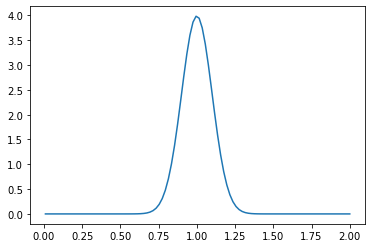

In [2]:
x = np.linspace(0.01, 2, num=100)

base = stats.norm(1, 0.1)

plt.plot(x, base.pdf(x))

np.trapz(base.pdf(x), x)

## Transformation

As we apply $f(x) = y = x^2$ we see that the result of the transformation doesn't suffice the requirements of a probability distribution, as $\int P(y)dy \neq 1$

5.641895835477563

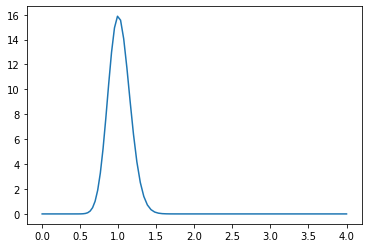

In [3]:
def f(x):
    return x**2

transformed = f(base.pdf(x))
plt.plot(f(x), transformed)

np.trapz(transformed, f(x))

# Change of variables

We want to transform $P(x)$ to $P(y)$ with $f: \mathbb{R}^n \mapsto \mathbb{R}^n $ and $f(x) = y$
The transformation blows up or shrinks the area/ volume (in N-D) of the distribution, so we need to determine a transformation so that:


$$ 
\begin{eqnarray}
\int P(x)dx &=&\int P(y)dy = 1 \\
P(x)dx &=&P(y)dy \\
P(y) &=&P(x)\frac{dx}{dy}
\end{eqnarray} $$

So to keep an integral of 1 for $P(y)$ (the definition of a probability distribution), we need to multiply $P(x)$ with its derivative w.r.t. $y$.
Therefore we need to express $x$ in $y$. This can be done if we only have invertible transformations.

$$\begin{eqnarray}
f(x) &=& y \\
f^{-1}(y) &=& x
\end{eqnarray} $$

$$\begin{eqnarray}
 P(y) &=& P(f^{-1}(y))\frac{\text{d}f^{-1}(y)}{\text{d}y} \\
 &=& P(f^{-1}(y))f'^{-1}(y)
\end{eqnarray} $$


0.9987379589284238

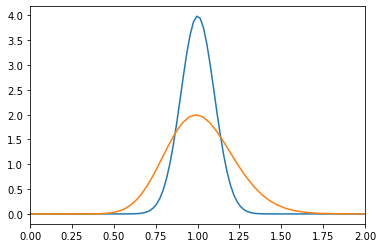

In [4]:
def f_i(y):
    return y**0.5

def f_i_prime(y):
    return 0.5*y**-0.5

assert np.allclose(f_i(f(x)),  x)

y = f(x)
px = base.pdf(x)

transformed = px * f_i_prime(f_i(y))

plt.plot(x, px)
plt.plot(y, transformed)
plt.xlim(0, 2)

np.trapz(transformed, y)

0.9987894616589734

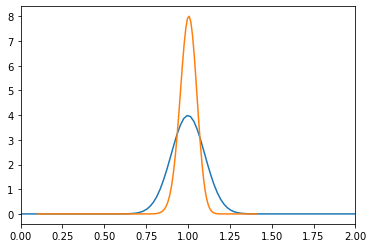

In [5]:
# Same principle, other transformation

def f(x):
    return x**0.5

def f_i(y):
    return y**2

def f_i_prime(y):
    return 2*y

assert np.allclose(f_i(f(x)),  x)

y = f(x)
px = base.pdf(x)

transformed = px * f_i_prime(f_i(y))

plt.plot(x, px)
plt.plot(y, transformed)
plt.xlim(0, 2)

np.trapz(transformed, y)

## Conditions
The transformations we've used were strictly increasing. 

In the example we've used above $\frac{dx}{dy}$ was positive, as the transformation was strictly increasing, in the strictly decreasing case, $\frac{dx}{dy}$ is negative and $P(y)=-P(x)\frac{dx}{dy}$. If we take the absolute value of the derivative we have one equation for both cases.

$$ 
\begin{eqnarray}
P(y)&=&P(x) \cdot \left| \frac{dx}{dy} \right| \\
 &=& P(f^{-1}(y)) \cdot \left| f'^{-1}(y)\right|
\end{eqnarray}
$$

The intuition of taking the modulus is that if the (local) rate of change of $x + dx = y + dy > 0$, then we can ensure ourselves that the rate of amount of probability is increasing, and the total amount of probability is preserved. This is ensured by conditioning $\frac{dx}{dy} \geq 0$.

![](img/absolute.png)

## Multiple dimensions
In N-D $\frac{dx}{dy}$ is expressed in the Jacobian matrix, i.e. the matrix with first order partial derivatives $\frac{\partial(x)}{\partial{y}}=\mathbf{J}$. This absolute value, is now a determinant, such that;

$$ 
\begin{eqnarray}
P(y)&=&P(f^{-1}(y)) \cdot \left| \det \frac{\partial{ f(y)^{-1} }}{\partial{y}} \right| \\
P(y)&=&P(f^{-1}(y)) \cdot \left| \det \mathbf{J}_{f^{-1}(y)} \right| \\
\end{eqnarray}
$$

The geometric meaning of the determinant is a scaling factor. $\det A$ tells us how much an n-dimensional volume is scaled by applying the transformation of $A$.

(50, 50, 2)


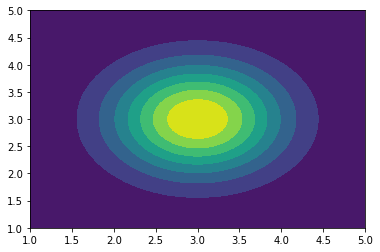

In [259]:
x1 = np.linspace(1, 5, num=50)
x2 = np.linspace(1, 5, num=50)
x1_s, x2_s = np.meshgrid(x1 ,x2)

base = stats.multivariate_normal(mean=[3, 3], cov=0.5)
assert base.pdf([3, 3]) > base.pdf([1, 1])

# field of all possible events X
x_field = np.concatenate([x1_s[..., None], x2_s[..., None]], axis=-1)
print(x_field.shape)

plt.contourf(x1_s, x2_s, base.pdf(x_field))

## Jacobian matrix.

Assume the function $f: \mathbb{R}^n \mapsto \mathbb{R}^m$. The jacobian is a 2D matrix, that stores on the partial derivatives of all the outputs and all the inputs. The width of the jacobian is equal to the functions input $n$. The height of the jacobian is equal to the functions output $m$.

$$ \mathbf{J} = \begin{bmatrix}
\frac{\partial f_1}{\partial x_1} & \dots & \frac{\partial f_1}{\partial x_n} \\[6pt]
\vdots & \ddots & \vdots \\[6pt]
\frac{\partial f_m}{\partial x_1} & \dots & \frac{\partial f_m}{\partial x_n} \\[6pt]
\end{bmatrix}$$

We will map 2D events to another domain. So we will have two inputs $n$ and two outputs $m$.

In [275]:
def f(x1, x2):
    return torch.exp(x1 / 3), x2**2

def f_i(y1, y2):
    return 3 * torch.log(y1), y2**0.5

x_field = torch.tensor(x_field)
# Transform x events to y events
y_field = np.concatenate(f(x_field[..., 0, None], x_field[..., 1, None]), axis=-1)


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


In [276]:
def create_det_jac(y_field):
    # create for every y1, y2 combination the determinant of the jacobian f_i(y1, y2)
    det_jac = np.zeros((y_field.shape[0], y_field.shape[1]))
    for i in range(y_field.shape[0]):
        for j in range(y_field.shape[1]):
            y_field = torch.tensor(y_field)
            y_field.requires_grad_(True);
            fiy = torch.cat(f_i(y_field[..., 0, None], y_field[..., 1, None]), dim=-1)
            fiy[i, j].sum().backward()
            
            # Ouputs of the partial derivatives are independent.  I.e. f1 is dependent of y1 and not y2
            # and vice versa f2 is dependent of y2 and not y1
            # therefore the multiplication w/ 0 
            row1 = y_field.grad[i, j].data.numpy() * np.array([1., 0.])
            row2 = y_field.grad[i, j].data.numpy() * np.array([0., 1.])
            
            det = np.linalg.det(np.array([row1, row2]))
            det_jac[i, j] = det
    return det_jac



/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


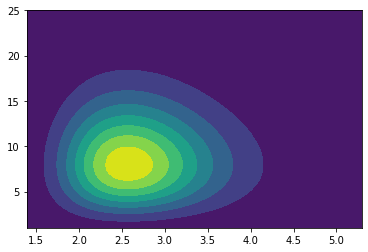

In [277]:
px = base.pdf(x_field)
transformed = px * np.abs(create_det_jac(y_field))
plt.contourf(y_field[..., 0], y_field[..., 1], transformed)

In [278]:
np.trapz(np.trapz(transformed, y_field[:, 0, 1], axis=0), y_field[0, :, 0])

0.9907110850291531